*Flow Capacity Variable, K-means*

In [12]:
# Importing the required packages
import calliope
import pandas as pd
from spores_algorithm import run_spores
from plotting_utilities import plot_dispatch, plot_capacity, plot_network
import matplotlib.pyplot as plt
import glob
import numpy as np
import os
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial.distance import cdist
import numpy as np

# Set the number of threads to 1
os.environ["OMP_NUM_THREADS"] = "1"


calliope.set_log_verbosity('INFO', include_solver_output=False) # Defines how much information you get 
                                                               #from the machine as the model gets built and run

Loads all SPORE NetCDF files, aggregates source capacities by technology for each SPORE, and builds a matrix with SPOREs as rows and technologies as columns.

In [13]:
# List all the SPORE files (adjust path pattern as needed)
spore_files = glob.glob('results/spores/*.nc')  # Adjust this if needed

# Initialize an empty list to hold the aggregated data for each SPORE
aggregated_data_list = []

# Iterate over each SPORE file
for file in spore_files:
    # Open the NetCDF file
    data = xr.open_dataset(file)
    
    # Convert source capacities to DataFrame
    data_source = data['flow_cap'].to_dataframe().reset_index()
    
    # Filter out any "_to_" techs and drop NaN values in flow_cap
    data_source = data_source[~data_source['techs'].str.contains(r'_to_', regex=True)]
    data_source = data_source.dropna(subset=['flow_cap'])
    
    # Aggregate the source capacities by tech
    aggregated_flow_cap = data_source.groupby('techs')['flow_cap'].sum().reset_index()
    
    # Convert the aggregated source capacities into a series with tech as the index
    aggregated_series = aggregated_flow_cap.set_index('techs')['flow_cap']
    
    spore_name = file.split('/')[-1].split('.')[0]  # Extracting 'maxnuc_spore_1' from the file name
    aggregated_series.name = spore_name  # Name the row by the SPORE name

    # Append the aggregated data (this will form the rows in the final matrix)
    aggregated_data_list.append(aggregated_series)

# Combine all SPORE aggregated data into a single DataFrame (with each SPORE as a row)
aggregated_matrix = pd.concat(aggregated_data_list, axis=1).T

# Set the column names to be the techs
aggregated_matrix.columns = aggregated_flow_cap['techs']
aggregated_matrix = aggregated_matrix.drop(columns=['lost_load'])
aggregated_all = aggregated_matrix.copy()
aggregated_matrix = aggregated_matrix.drop(columns=['import_power','export_power','demand_power','curtailment'])

# Show the resulting matrix
aggregated_matrix


techs,battery,bioenergy,ccgt,coal,hydrogen_power_storage,nuclear,solar_pv,wind_offshore,wind_onshore
spore_5,0.021306,3998.989336,3675.952809,1263.934835,0.002485,485.076166,24359.004328,4756.987354,6956.888585
minons_spore_8,1.668140,5549.403476,1378.567905,2068.114857,0.167569,493.506789,24359.003173,4756.645760,6953.000001
minoff_spore_7,0.442854,4057.682306,4363.532005,1083.344938,0.045860,487.120474,24359.000491,4748.000922,6953.457081
maxpv_spore_3,0.003669,5411.830325,4289.607355,0.031734,0.000359,485.010454,41873.275417,4756.999069,6953.000081
maxbat_spore_3,211.449166,8960.788041,902.070283,0.008979,0.000106,485.003073,24359.000073,4756.998508,6953.000025
...,...,...,...,...,...,...,...,...,...
minpv_spore_4,4.783517,4971.355842,3124.248330,1178.944061,0.437834,507.644718,24359.000001,4757.152753,6954.577481
maxoff_spore_5,0.007640,6029.604812,2662.138660,0.056897,0.000637,485.020681,24359.001065,12423.648215,6953.000423
minbat_spore_1,0.000062,8215.482213,2638.025995,381.163716,5.734455,614.514479,24359.000286,4756.674389,6957.151391
maxbio_spore_10,16.806411,12000.000000,337.165500,83.532898,1.993511,522.006372,24359.000170,4754.232221,6953.307272


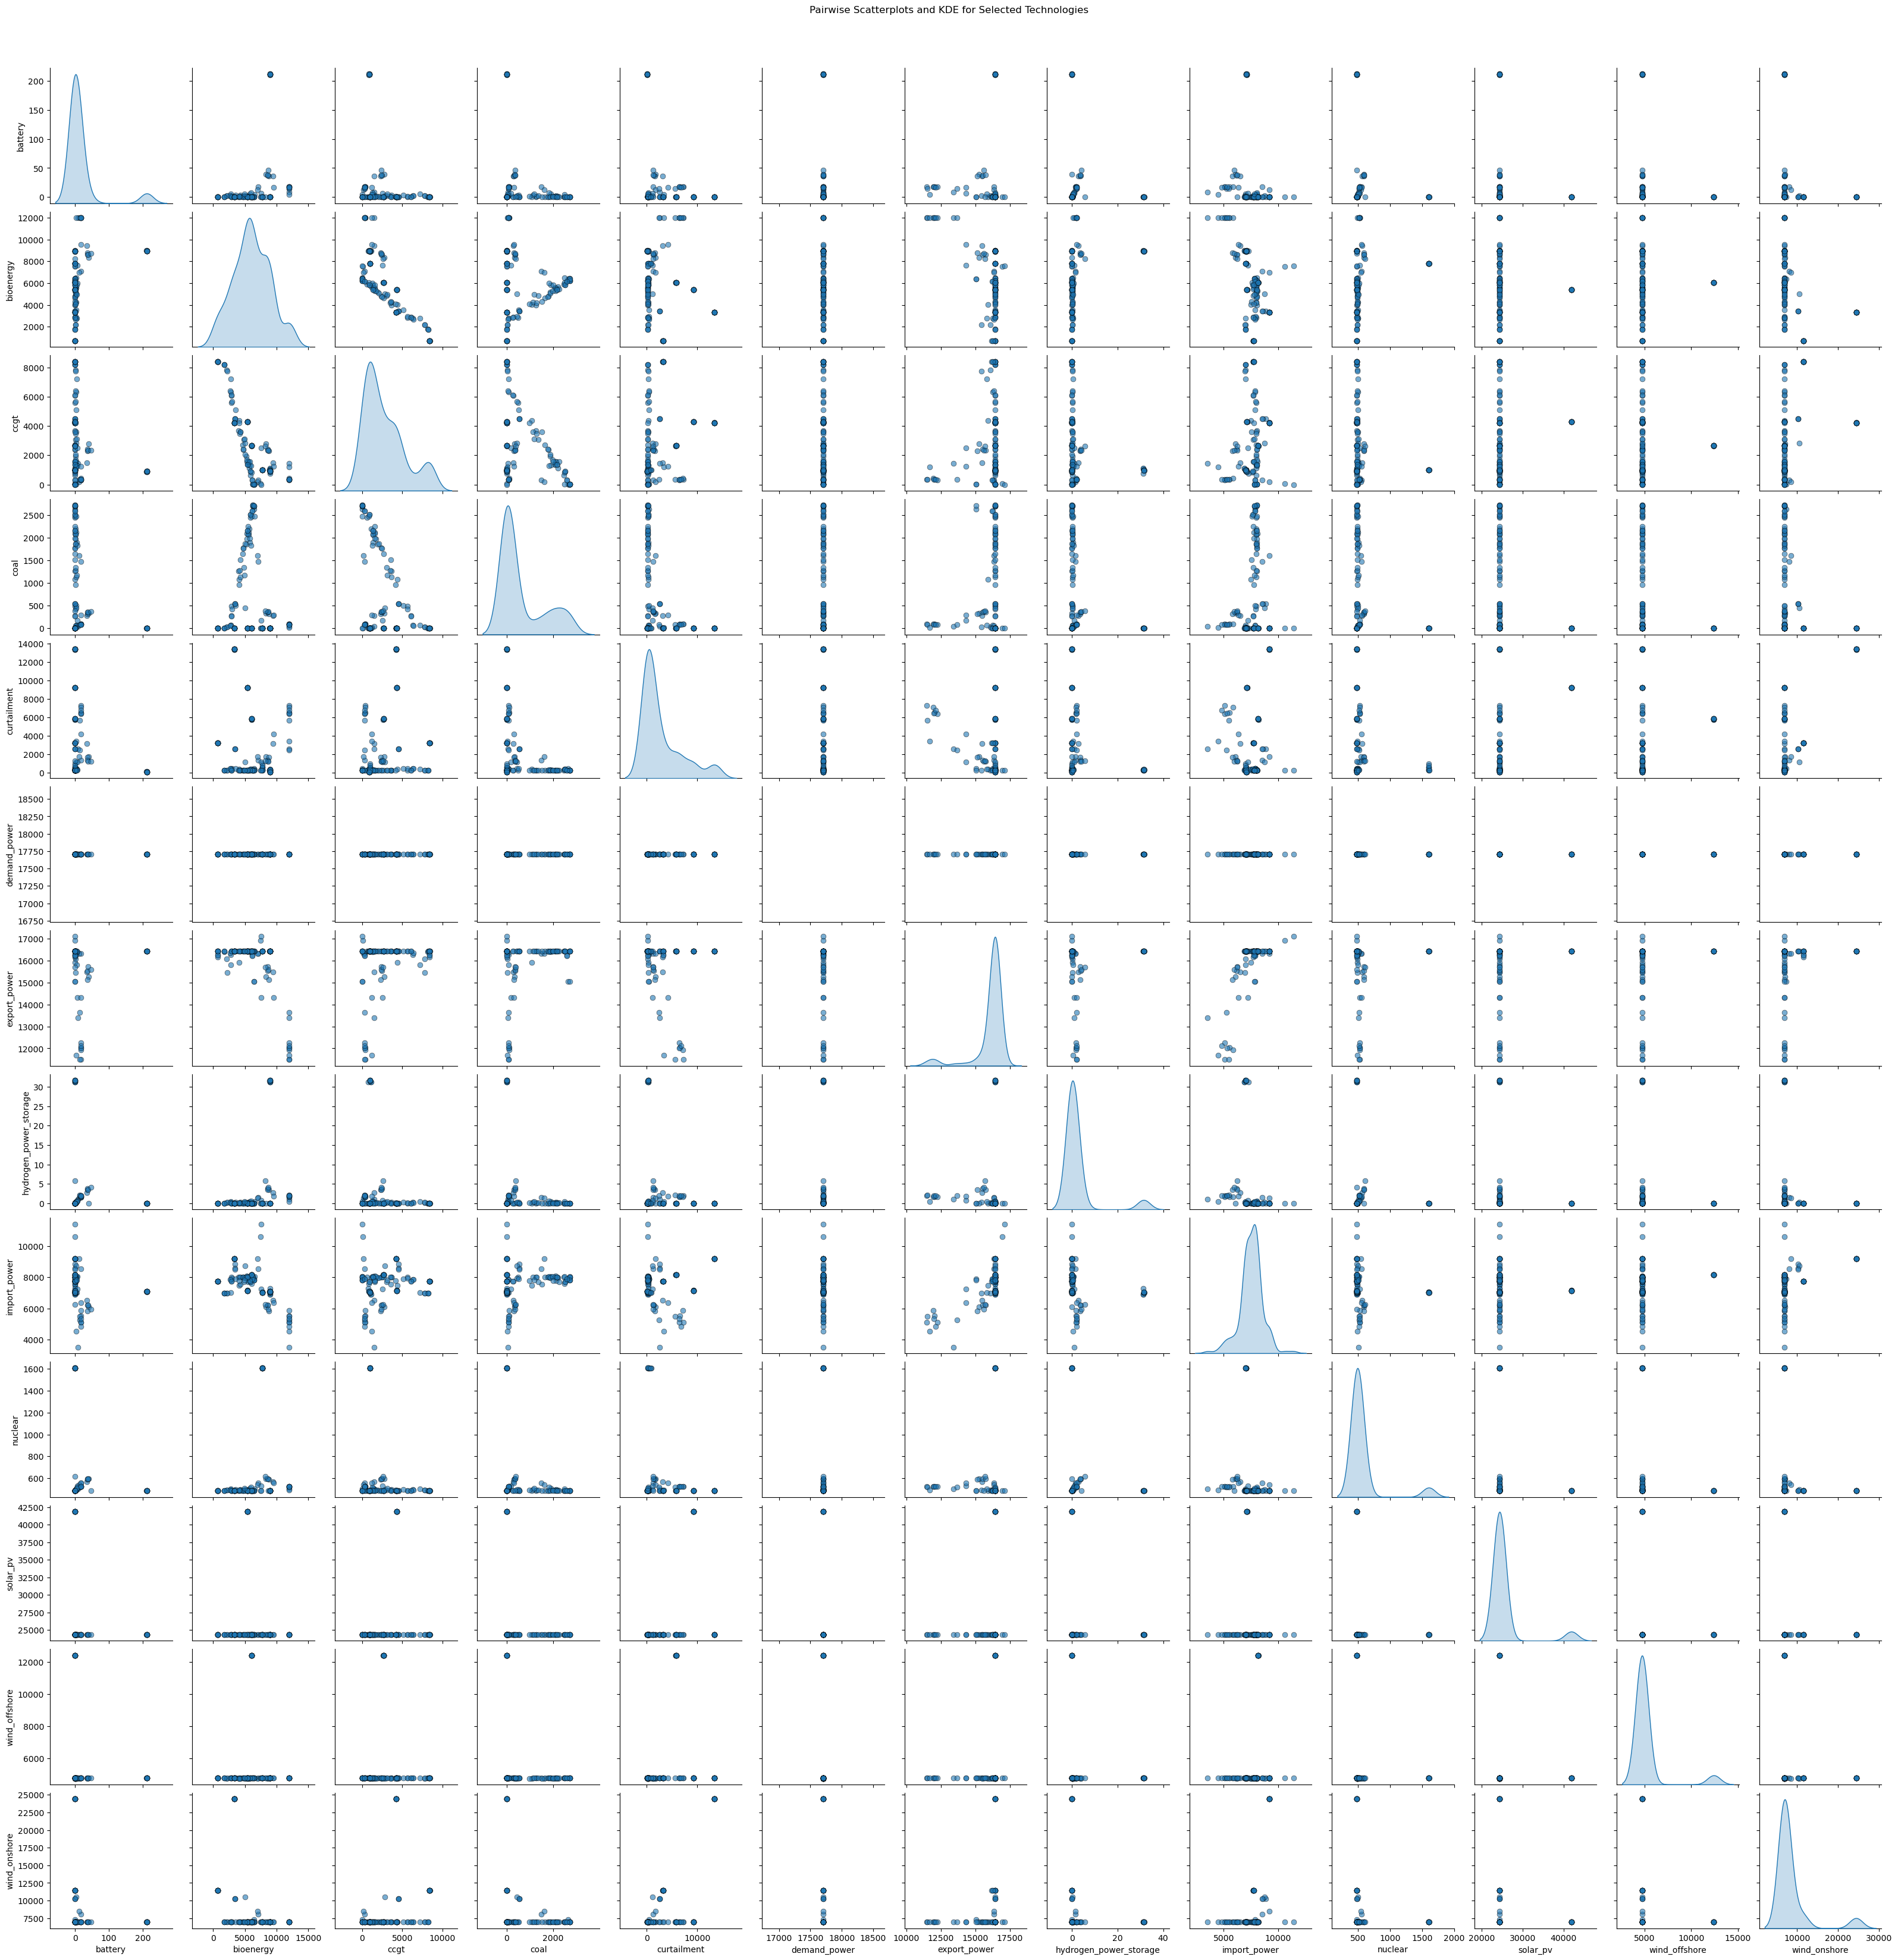

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# If the dataset is large, you may want to select only a subset of columns (features)
# For example, select a few key technologies:
features = ['battery', 'bioenergy', 'ccgt', 'coal', 'nuclear', 'solar_pv', 'wind_offshore', 'wind_onshore']

# Create the pairplot
sns.pairplot(aggregated_all[aggregated_all.columns], diag_kind='kde', plot_kws={'alpha':0.6, 's':40, 'edgecolor':'k'})

plt.suptitle('Pairwise Scatterplots and KDE for Selected Technologies', y=1.02)
plt.show()


Standardizes (scales) the aggregated matrix across all technologies using sklearn's StandardScaler.

In [15]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
matrix_scaled = scaler.fit_transform(aggregated_matrix)  # Normalize across all technologies


Uses the Elbow Method to determine the optimal number of clusters (K) for KMeans by plotting inertia.

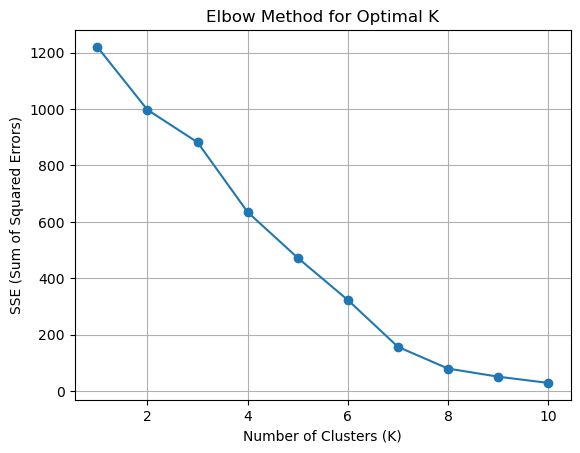

In [16]:
from sklearn.cluster import KMeans

# Reduce dimensionality
pca = PCA(n_components=6)
X_pca = pca.fit_transform(matrix_scaled)

# Try different values of K and calculate the inertia (sum of squared distances)
inertia = []
k_range = range(1, 11)  # Test for K = 1 to 10 clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Plot inertia to find the "elbow" point
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.grid(True)
plt.show()      


Applies KMeans clustering with the chosen number of clusters, assigns cluster labels to each SPORE, and adds them to the aggregated matrix.

In [17]:
# Apply K-means with the chosen number of clusters (e.g., best_k)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

# Add the cluster labels to the DataFrame
aggregated_matrix['Cluster'] = kmeans_labels
aggregated_all['Cluster'] = kmeans_labels

# Show the results
aggregated_matrix


techs,battery,bioenergy,ccgt,coal,hydrogen_power_storage,nuclear,solar_pv,wind_offshore,wind_onshore,Cluster
spore_5,0.021306,3998.989336,3675.952809,1263.934835,0.002485,485.076166,24359.004328,4756.987354,6956.888585,1
minons_spore_8,1.668140,5549.403476,1378.567905,2068.114857,0.167569,493.506789,24359.003173,4756.645760,6953.000001,1
minoff_spore_7,0.442854,4057.682306,4363.532005,1083.344938,0.045860,487.120474,24359.000491,4748.000922,6953.457081,1
maxpv_spore_3,0.003669,5411.830325,4289.607355,0.031734,0.000359,485.010454,41873.275417,4756.999069,6953.000081,1
maxbat_spore_3,211.449166,8960.788041,902.070283,0.008979,0.000106,485.003073,24359.000073,4756.998508,6953.000025,1
...,...,...,...,...,...,...,...,...,...,...
minpv_spore_4,4.783517,4971.355842,3124.248330,1178.944061,0.437834,507.644718,24359.000001,4757.152753,6954.577481,1
maxoff_spore_5,0.007640,6029.604812,2662.138660,0.056897,0.000637,485.020681,24359.001065,12423.648215,6953.000423,1
minbat_spore_1,0.000062,8215.482213,2638.025995,381.163716,5.734455,614.514479,24359.000286,4756.674389,6957.151391,1
maxbio_spore_10,16.806411,12000.000000,337.165500,83.532898,1.993511,522.006372,24359.000170,4754.232221,6953.307272,1


Extracts general SPORE categories from SPORE names, groups by cluster and category, and counts occurrences to show the distribution of SPORE types in each cluster.

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Check the explained variance ratio
explained_variance = pca.explained_variance_ratio_
total_variance_explained = np.sum(explained_variance)

print(f"Explained variance by Component 1: {explained_variance[0]:.4f}")
print(f"Explained variance by Component 2: {explained_variance[1]:.4f}")
print(f"Total variance explained by the first 6 components: {total_variance_explained:.4f}")

Explained variance by Component 1: 0.2637
Explained variance by Component 2: 0.1518
Total variance explained by the first 6 components: 0.8978


In [19]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score, calinski_harabasz_score

db_score = davies_bouldin_score(X_pca, kmeans_labels)
print(f"Davies-Bouldin score: {db_score:.3f}")
db_score_orig = davies_bouldin_score(matrix_scaled, kmeans_labels)
print(f"DB score on original space: {db_score_orig:.3f}")

# Clusters from PCA-based clustering
ch_score_pca = calinski_harabasz_score(X_pca, kmeans_labels)
print(f"CH score on PCA space: {ch_score_pca:.2f}")
ch_score_orig = calinski_harabasz_score(matrix_scaled, kmeans_labels)
print(f"CH score on original space: {ch_score_orig:.2f}")


score = silhouette_score(X_pca, kmeans_labels)
print(f'Silhouette score: {score:.3f}')
sh_score_orig = silhouette_score(matrix_scaled, kmeans_labels)
print(f"SC score on original space: {sh_score_orig:.3f}")

Davies-Bouldin score: 0.808
DB score on original space: 0.942
CH score on PCA space: 45.22
CH score on original space: 38.42
Silhouette score: 0.414
SC score on original space: 0.393


In [20]:
metrics_summary = {
    'Davies-Bouldin': db_score_orig,
    'Calinski-Harabasz': ch_score_orig,
    'Silhouette': sh_score_orig
}
metrics_summary = pd.DataFrame({
    'score': ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz'],
    'value': [sh_score_orig, db_score_orig, ch_score_orig]
})


In [21]:
# Dynamically extract the general SPORE category from the 'techs' index by splitting the names
aggregated_matrix_count = aggregated_matrix.copy()

aggregated_matrix_count['spore_category_general'] = aggregated_matrix_count.index.to_series().apply(lambda x: x.split('_spore')[0])

# Now, group by 'Cluster' and 'spore_category_general' and count the occurrences
cluster_spore_count = aggregated_matrix_count.groupby(['Cluster', 'spore_category_general']).size().unstack(fill_value=0)

# Show the resulting table
cluster_spore_count['spore_main'] = cluster_spore_count[['spore_1', 'spore_2', 'spore_3', 'spore_4', 'spore_5', 'spore_6', 'spore_7', 'spore_8', 'spore_9', 'spore_10']].sum(axis=1)
cluster_spore_count = cluster_spore_count.drop(columns=['spore_1', 'spore_2', 'spore_3', 'spore_4', 'spore_5', 'spore_6', 'spore_7', 'spore_8', 'spore_9', 'spore_10'])

cluster_spore_count

spore_category_general,maxbat,maxbio,maxhtp,maxnuc,maxoff,maxons,maxpv,minbat,minbio,minhtp,minnuc,minoff,minons,minpv,spore_baseline,spore_main
Cluster,,,,,,,,,,,,,,,,
0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10,10,0,0,10,0,10,7,0,7,7,9,7,7,1,10
2,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,10,0,3,10,3,3,1,3,3,0,0


Calculates the mean source capacity for each technology within each cluster, summarizing the average configuration per cluster.

In [22]:
aggregated_matrix

techs,battery,bioenergy,ccgt,coal,hydrogen_power_storage,nuclear,solar_pv,wind_offshore,wind_onshore,Cluster
spore_5,0.021306,3998.989336,3675.952809,1263.934835,0.002485,485.076166,24359.004328,4756.987354,6956.888585,1
minons_spore_8,1.668140,5549.403476,1378.567905,2068.114857,0.167569,493.506789,24359.003173,4756.645760,6953.000001,1
minoff_spore_7,0.442854,4057.682306,4363.532005,1083.344938,0.045860,487.120474,24359.000491,4748.000922,6953.457081,1
maxpv_spore_3,0.003669,5411.830325,4289.607355,0.031734,0.000359,485.010454,41873.275417,4756.999069,6953.000081,1
maxbat_spore_3,211.449166,8960.788041,902.070283,0.008979,0.000106,485.003073,24359.000073,4756.998508,6953.000025,1
...,...,...,...,...,...,...,...,...,...,...
minpv_spore_4,4.783517,4971.355842,3124.248330,1178.944061,0.437834,507.644718,24359.000001,4757.152753,6954.577481,1
maxoff_spore_5,0.007640,6029.604812,2662.138660,0.056897,0.000637,485.020681,24359.001065,12423.648215,6953.000423,1
minbat_spore_1,0.000062,8215.482213,2638.025995,381.163716,5.734455,614.514479,24359.000286,4756.674389,6957.151391,1
maxbio_spore_10,16.806411,12000.000000,337.165500,83.532898,1.993511,522.006372,24359.000170,4754.232221,6953.307272,1


[2025-06-15 15:05:14] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_1814/2101165774.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_clusters))



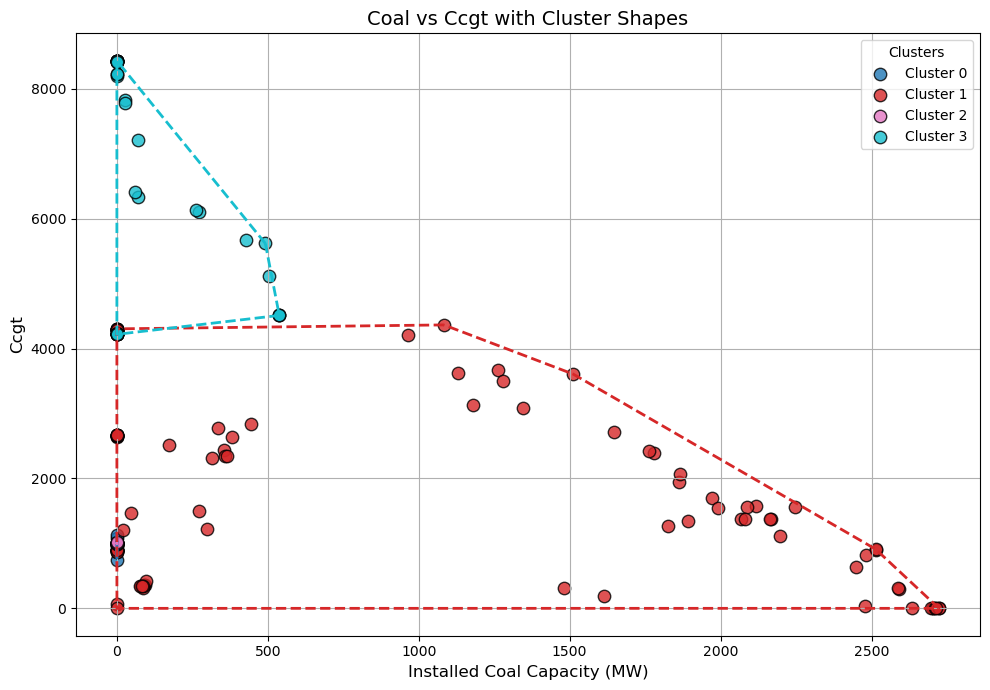

In [23]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.spatial import ConvexHull

# Extract x, y, and cluster labels
x = aggregated_all['coal'].values
y = aggregated_all['ccgt'].values
cluster_labels = aggregated_all['Cluster'].values

# Unique clusters and colormap
unique_clusters = np.unique(cluster_labels)
cmap = cm.get_cmap('tab10', len(unique_clusters))

plt.figure(figsize=(10, 7))

# Plot each cluster individually
for i, cluster in enumerate(unique_clusters):
    mask = cluster_labels == cluster
    x_cluster = x[mask]
    y_cluster = y[mask]

    # Plot cluster points
    plt.scatter(x_cluster, y_cluster,
                c=[cmap(i)], label=f'Cluster {cluster}',
                s=80, edgecolor='k', alpha=0.8)

    # Add convex hull if there are enough points
    if len(x_cluster) >= 3:
        points = np.column_stack((x_cluster, y_cluster))
        hull = ConvexHull(points)
        hull_points = np.append(hull.vertices, hull.vertices[0])  # close loop
        plt.plot(points[hull_points, 0], points[hull_points, 1],
                 linestyle='--', linewidth=2, color=cmap(i))

# Labels and legend
plt.xlabel('Installed Coal Capacity (MW)', fontsize=12)
plt.ylabel('Ccgt', fontsize=12)
plt.title('Coal vs Ccgt with Cluster Shapes', fontsize=14)
plt.grid(True)
plt.legend(title='Clusters', loc='best')
plt.tight_layout()
plt.show()

[2025-06-15 15:05:14] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_1814/1628896700.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_clusters))



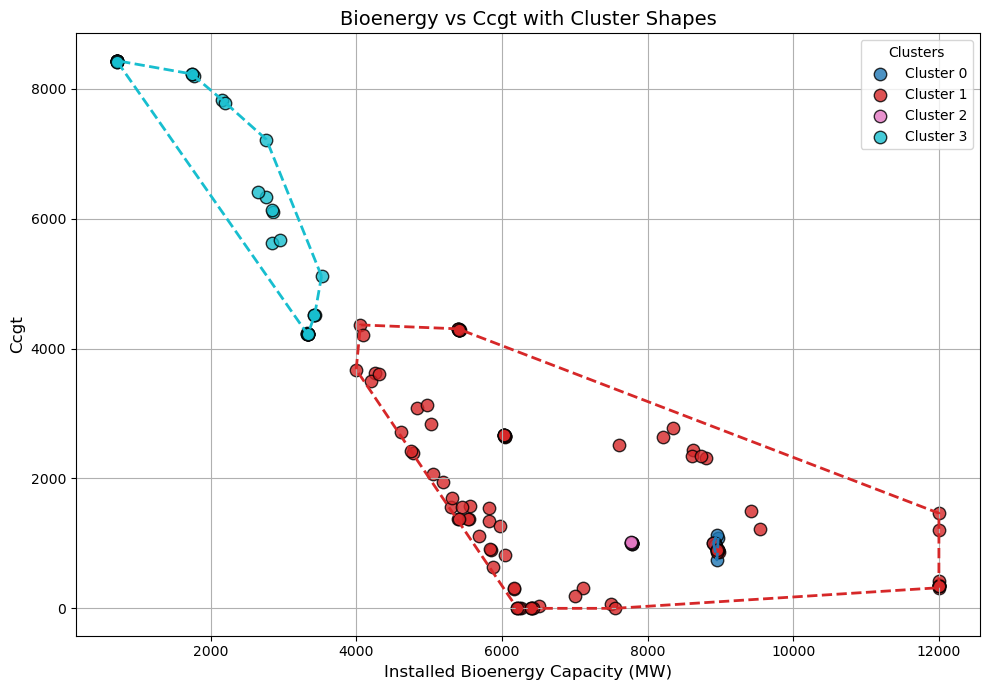

In [24]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.spatial import ConvexHull

# Extract x, y, and cluster labels
x = aggregated_all['bioenergy'].values
y = aggregated_all['ccgt'].values
cluster_labels = aggregated_all['Cluster'].values

# Unique clusters and colormap
unique_clusters = np.unique(cluster_labels)
cmap = cm.get_cmap('tab10', len(unique_clusters))

plt.figure(figsize=(10, 7))

# Plot each cluster individually
for i, cluster in enumerate(unique_clusters):
    mask = cluster_labels == cluster
    x_cluster = x[mask]
    y_cluster = y[mask]

    # Plot cluster points
    plt.scatter(x_cluster, y_cluster,
                c=[cmap(i)], label=f'Cluster {cluster}',
                s=80, edgecolor='k', alpha=0.8)

    # Add convex hull if there are enough points
    if len(x_cluster) >= 3:
        points = np.column_stack((x_cluster, y_cluster))
        hull = ConvexHull(points)
        hull_points = np.append(hull.vertices, hull.vertices[0])  # close loop
        plt.plot(points[hull_points, 0], points[hull_points, 1],
                 linestyle='--', linewidth=2, color=cmap(i))

# Labels and legend
plt.xlabel('Installed Bioenergy Capacity (MW)', fontsize=12)
plt.ylabel('Ccgt', fontsize=12)
plt.title('Bioenergy vs Ccgt with Cluster Shapes', fontsize=14)
plt.grid(True)
plt.legend(title='Clusters', loc='best')
plt.tight_layout()
plt.show()

[2025-06-15 15:05:14] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_1814/265102856.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_clusters))



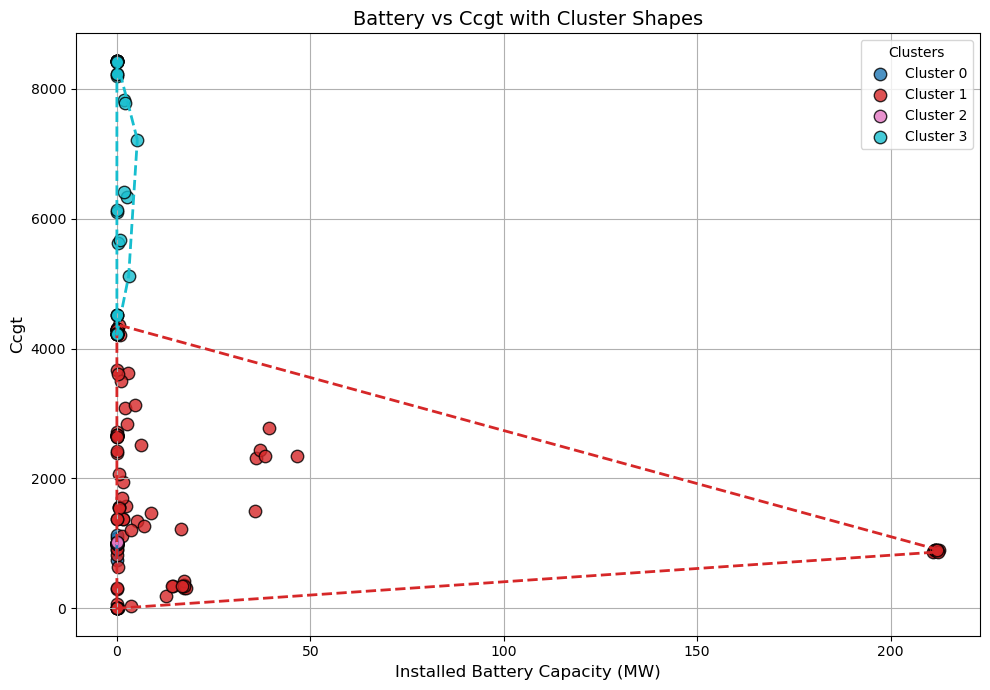

In [25]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.spatial import ConvexHull

# Extract x, y, and cluster labels
x = aggregated_all['battery'].values
y = aggregated_all['ccgt'].values
cluster_labels = aggregated_all['Cluster'].values

# Unique clusters and colormap
unique_clusters = np.unique(cluster_labels)
cmap = cm.get_cmap('tab10', len(unique_clusters))

plt.figure(figsize=(10, 7))

# Plot each cluster individually
for i, cluster in enumerate(unique_clusters):
    mask = cluster_labels == cluster
    x_cluster = x[mask]
    y_cluster = y[mask]

    # Plot cluster points
    plt.scatter(x_cluster, y_cluster,
                c=[cmap(i)], label=f'Cluster {cluster}',
                s=80, edgecolor='k', alpha=0.8)

    # Add convex hull if there are enough points
    if len(x_cluster) >= 3:
        points = np.column_stack((x_cluster, y_cluster))
        hull = ConvexHull(points)
        hull_points = np.append(hull.vertices, hull.vertices[0])  # close loop
        plt.plot(points[hull_points, 0], points[hull_points, 1],
                 linestyle='--', linewidth=2, color=cmap(i))

# Labels and legend
plt.xlabel('Installed Battery Capacity (MW)', fontsize=12)
plt.ylabel('Ccgt', fontsize=12)
plt.title('Battery vs Ccgt with Cluster Shapes', fontsize=14)
plt.grid(True)
plt.legend(title='Clusters', loc='best')
plt.tight_layout()
plt.show()

[2025-06-15 15:05:18] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_1814/1085573807.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_clusters))



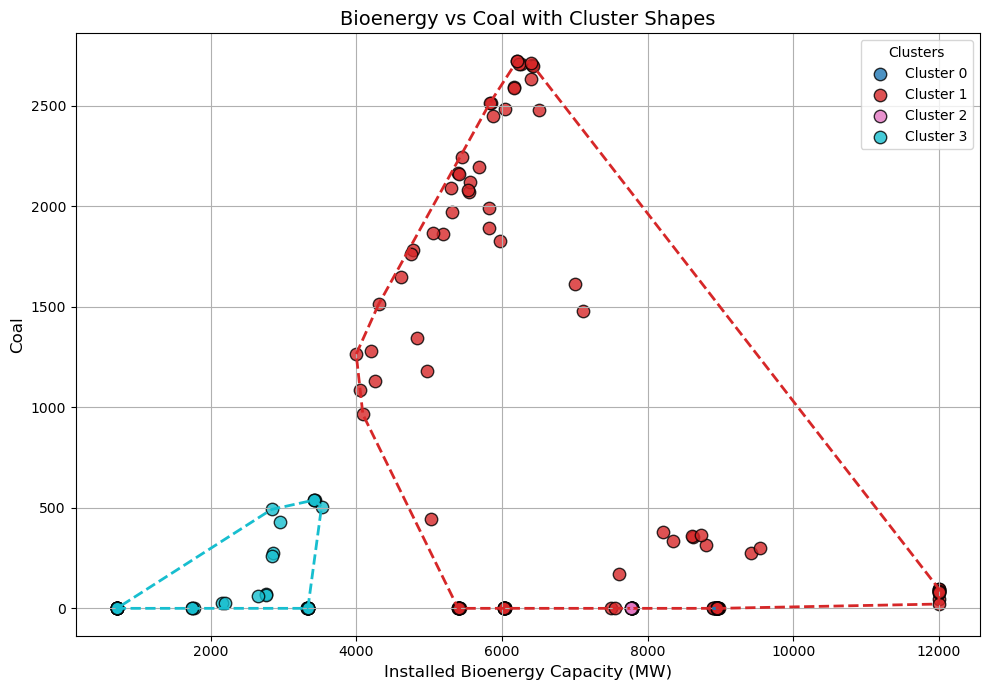

In [26]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.spatial import ConvexHull

# Extract x, y, and cluster labels
x = aggregated_all['bioenergy'].values
y = aggregated_all['coal'].values
cluster_labels = aggregated_all['Cluster'].values

# Unique clusters and colormap
unique_clusters = np.unique(cluster_labels)
cmap = cm.get_cmap('tab10', len(unique_clusters))

plt.figure(figsize=(10, 7))

# Plot each cluster individually
for i, cluster in enumerate(unique_clusters):
    mask = cluster_labels == cluster
    x_cluster = x[mask]
    y_cluster = y[mask]

    # Plot cluster points
    plt.scatter(x_cluster, y_cluster,
                c=[cmap(i)], label=f'Cluster {cluster}',
                s=80, edgecolor='k', alpha=0.8)

    # Add convex hull if there are enough points
    if len(x_cluster) >= 3:
        points = np.column_stack((x_cluster, y_cluster))
        hull = ConvexHull(points)
        hull_points = np.append(hull.vertices, hull.vertices[0])  # close loop
        plt.plot(points[hull_points, 0], points[hull_points, 1],
                 linestyle='--', linewidth=2, color=cmap(i))

# Labels and legend
plt.xlabel('Installed Bioenergy Capacity (MW)', fontsize=12)
plt.ylabel('Coal', fontsize=12)
plt.title('Bioenergy vs Coal with Cluster Shapes', fontsize=14)
plt.grid(True)
plt.legend(title='Clusters', loc='best')
plt.tight_layout()
plt.show()


In [27]:
# Group by 'Cluster' and calculate the mean for each technology
cluster_summary = aggregated_matrix.groupby('Cluster').mean()

# Show the resulting cluster summary
cluster_summary


techs,battery,bioenergy,ccgt,coal,hydrogen_power_storage,nuclear,solar_pv,wind_offshore,wind_onshore
Cluster,,,,,,,,,
0,0.003693,8935.340140,985.728641,0.033519,31.467729,485.011004,24359.000018,4756.997514,6953.000063
1,27.288578,6988.145760,1792.615295,945.902430,0.521927,499.972473,26202.613889,5562.538370,7022.792468
2,0.001425,7782.069499,1002.410272,0.013257,0.000138,1606.226907,24359.000136,4756.998190,6953.000042
3,0.502512,2320.598937,6356.711849,106.340718,0.047942,486.866583,24359.001113,4756.699502,13329.806744


Plots a bar chart of the average source capacities by technology for each cluster.

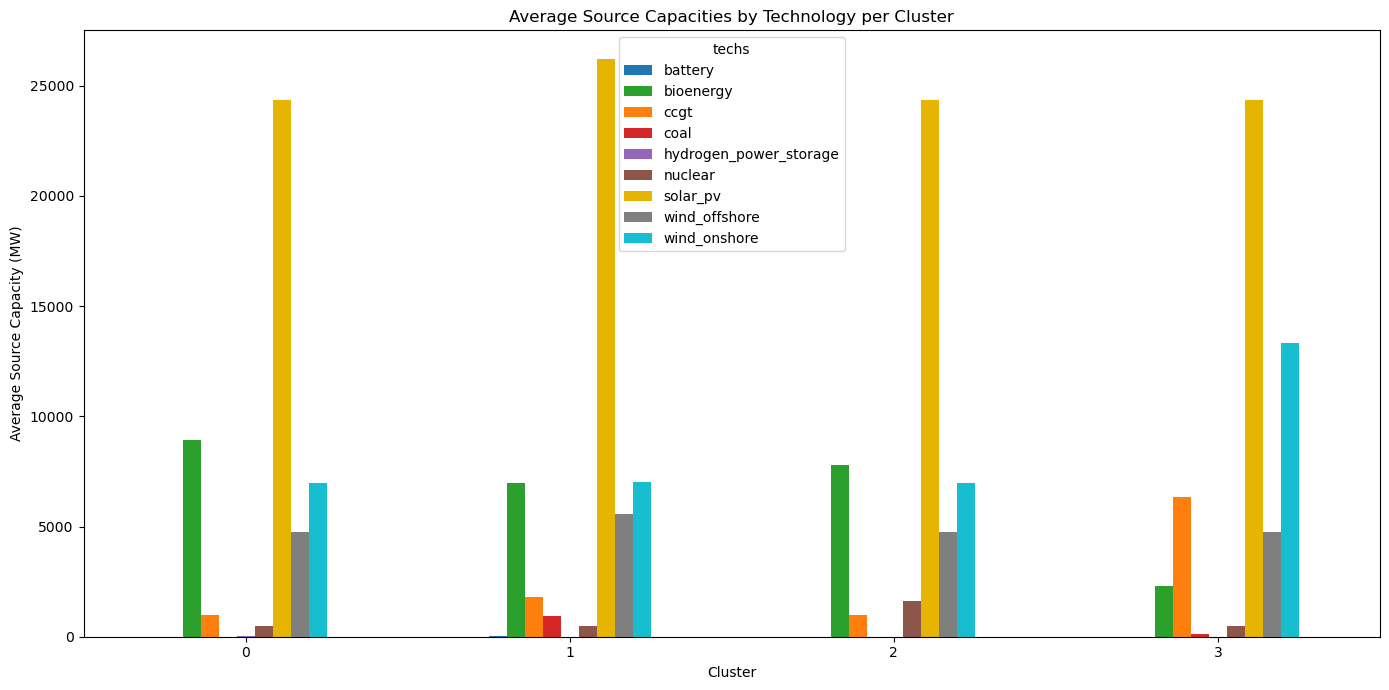

In [28]:
colors = ['#1f77b4','#2ca02c','#ff7f0e', '#d62728', '#9467bd', '#8c564b',"#e6b503", '#7f7f7f', '#17becf']
# Plot bar chart for each cluster
cluster_summary.plot(kind='bar', figsize=(14, 7), color=colors)

plt.title('Average Source Capacities by Technology per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Source Capacity (MW)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

[2025-06-15 15:05:21] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_1814/1140109240.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_clusters))



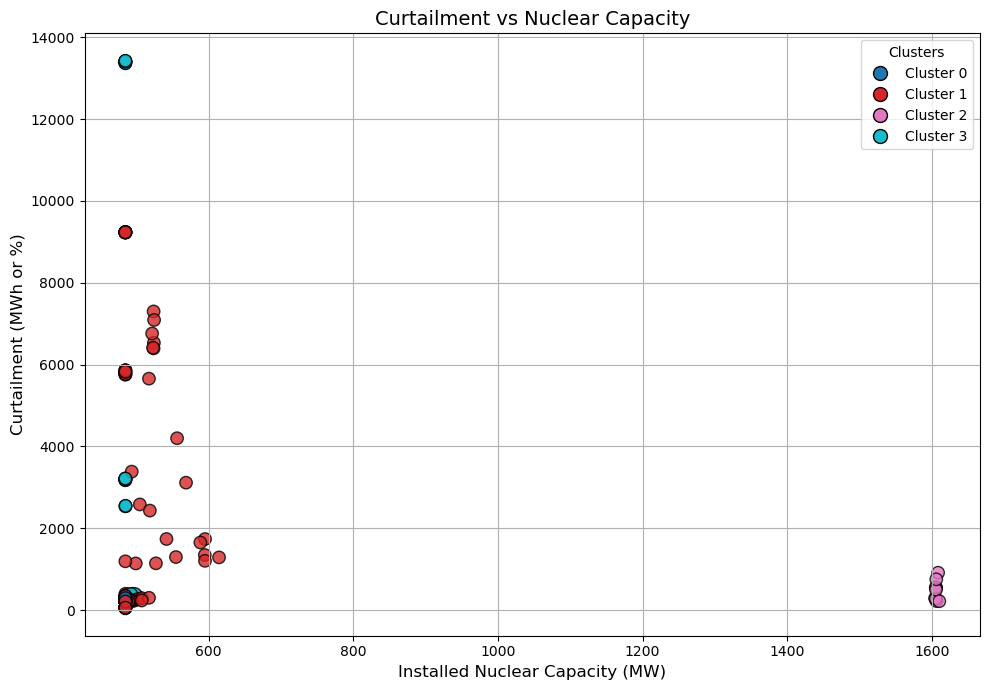

In [29]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Extract x, y, and cluster labels
x = aggregated_all['nuclear']
y = aggregated_all['curtailment']
cluster_labels = aggregated_all['Cluster']

# Identify unique clusters and generate colors
unique_clusters = np.unique(cluster_labels)
cmap = cm.get_cmap('tab10', len(unique_clusters))
colors = [cmap(i) for i in cluster_labels]

# Create the plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(x, y, c=cluster_labels, cmap='tab10', s=80, edgecolor='k', alpha=0.8)

# Add axis labels and title
plt.xlabel('Installed Nuclear Capacity (MW)', fontsize=12)
plt.ylabel('Curtailment (MWh or %)', fontsize=12)
plt.title('Curtailment vs Nuclear Capacity', fontsize=14)
plt.grid(True)

# Create a custom legend
handles = [plt.Line2D([], [], marker='o', color='w',
                      label=f'Cluster {label}',
                      markerfacecolor=cmap(i), markersize=10, markeredgecolor='k')
           for i, label in enumerate(unique_clusters)]
plt.legend(handles=handles, title="Clusters", loc='best')

plt.tight_layout()
plt.show()


Finds the configuration closest to the centroid for each cluster (representative configuration), and plots the technology capacities for these representative SPOREs.

Cluster 1 - Shape of cluster_configs: (95, 9)
Cluster 3 - Shape of cluster_configs: (36, 9)
Cluster 2 - Shape of cluster_configs: (10, 9)
Cluster 0 - Shape of cluster_configs: (10, 9)
Representative configurations: ['spore_3', 'minbio_spore_10', 'maxnuc_spore_5', 'maxhtp_spore_6']


<Figure size 1400x700 with 0 Axes>

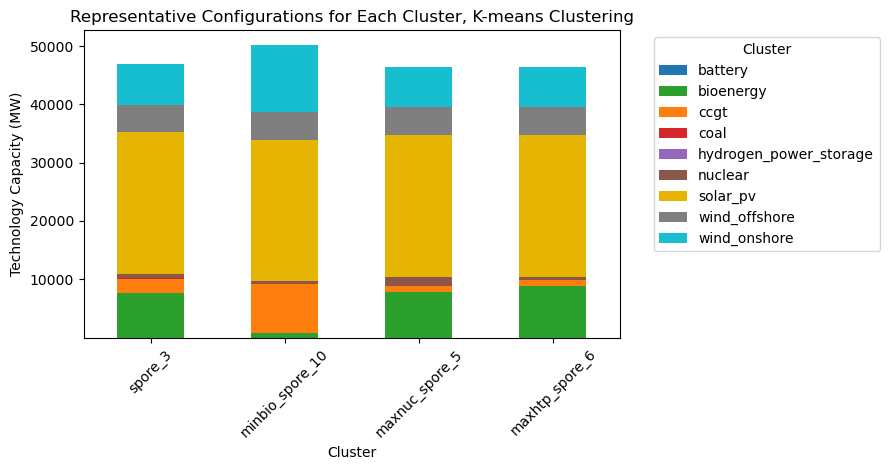

In [30]:
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial.distance import cdist
import numpy as np
import seaborn as sns

# Assuming 'aggregated_matrix' is your DataFrame with the 'Cluster' and technology columns
# 1. Compute the centroids of each cluster (mean of each technology in each cluster)
cluster_centroids = aggregated_matrix.groupby('Cluster').mean()

# 2. Find the configuration closest to the centroid for each cluster
representative_configs = []

for cluster in aggregated_matrix['Cluster'].unique():
    # Get the configurations in the current cluster
    cluster_configs = aggregated_matrix[aggregated_matrix['Cluster'] == cluster].drop(columns=['Cluster'])

    # Print the shape of the data to verify it's correct
    print(f"Cluster {cluster} - Shape of cluster_configs: {cluster_configs.shape}")

    # Calculate the centroid for the current cluster
    centroid = cluster_centroids.loc[cluster]

    # Compute the Euclidean distances between each configuration and the centroid
    distances = cdist(cluster_configs, centroid.values.reshape(1, -1), metric='euclidean')

    # Get the index of the closest configuration (minimum distance)
    closest_index = np.argmin(distances)
    representative_config = cluster_configs.iloc[closest_index].name

    # Append the representative configuration's index
    representative_configs.append(representative_config)

# Print the representative configurations' indices
print(f"Representative configurations: {representative_configs}")

# 3. Retrieve the representative configurations from the 'aggregated_matrix'
df_representative_configs = aggregated_matrix.loc[representative_configs]

import seaborn as sns

colors = ['#1f77b4','#2ca02c','#ff7f0e', '#d62728', '#9467bd', '#8c564b',"#e6b503", '#7f7f7f', '#17becf']

# 4. Plot the representative configurations (one bar plot per cluster)
plt.figure(figsize=(14, 7))
df_representative_configs.drop(columns=['Cluster']).plot(kind='bar', stacked=True, color=colors)

# Add titles and labels
plt.title('Representative Configurations for Each Cluster, K-means Clustering')
plt.xlabel('Cluster')
plt.ylabel('Technology Capacity (MW)')
plt.xticks(range(len(df_representative_configs)), labels=representative_configs, rotation=45)
plt.tight_layout()
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()




 Loads all SPORE NetCDF files again, extracts systemwide levelized cost and capacity factor for each technology, and builds a performance metrics matrix indexed by SPORE and technology.

In [31]:
import glob
import xarray as xr
import pandas as pd

# List all the SPORE files (adjust path pattern as needed)
spore_files = glob.glob('results/spores/*.nc')  # Adjust this if needed

# Initialize an empty list to hold the performance metrics for each SPORE
performance_metrics_list = []

# Iterate over each SPORE file
for file in spore_files:
    # Open the NetCDF file
    data = xr.open_dataset(file)
    
    # Extract systemwide levelized cost (LCOE)
    data_sys_LCOE = data['systemwide_levelised_cost'].to_dataframe().reset_index()
    data_sys_LCOE = data_sys_LCOE[data_sys_LCOE['costs'] == 'monetary']  # Filter for monetary costs
    data_sys_LCOE = data_sys_LCOE[data_sys_LCOE['techs'] != 'lost_load']  # Exclude 'lost_load'
    data_sys_LCOE = data_sys_LCOE[~data_sys_LCOE['techs'].str.contains(r'_to_', regex=True)]  # Exclude techs with '_to_'
    data_sys_LCOE = data_sys_LCOE.drop(columns=['costs', 'carriers'])  # Drop unnecessary columns
    data_sys_LCOE = data_sys_LCOE[(data_sys_LCOE['techs'] != 'curtailment')&(data_sys_LCOE['techs'] != 'demand_power')&(data_sys_LCOE['techs'] != 'export_power')] # Exclude 'curtailment'
    
    # Extract systemwide capacity factor
    data_sys_cap = data['systemwide_capacity_factor'].to_dataframe().reset_index()
    data_sys_cap = data_sys_cap[~data_sys_cap['techs'].str.contains(r'_to_', regex=True)]  # Exclude techs with '_to_'
    data_sys_cap = data_sys_cap.drop(columns=['carriers'])  # Drop unnecessary columns
    data_sys_cap = data_sys_cap[(data_sys_cap['techs'] != 'lost_load') & (data_sys_cap['techs'] != 'curtailment')]
    data_sys_cap = data_sys_cap[(data_sys_cap['techs'] != 'demand_power') & (data_sys_cap['techs'] != 'export_power')]  # Exclude 'demand_power' and 'export_power'
    
    # Extract the SPORE name from the file name (e.g., 'maxnuc_spore_1')
    spore_name = file.split('/')[-1].split('.')[0]  # Extracting 'maxnuc_spore_1' from the file name
    
    # Merge the data for the current SPORE (levelized cost and capacity factor)
    performance_metrics_df = pd.DataFrame({
        'systemwide_levelized_cost': data_sys_LCOE.set_index('techs')['systemwide_levelised_cost'],
        'systemwide_capacity_factor': data_sys_cap.set_index('techs')['systemwide_capacity_factor']
    })
    
    # Add the 'techs' column back to the DataFrame for proper indexing
    performance_metrics_df['techs'] = performance_metrics_df.index
    
    # Add the SPORE name as a column for identification
    performance_metrics_df['spore_name'] = spore_name
    
    # Append the performance metrics for this SPORE to the list
    performance_metrics_list.append(performance_metrics_df)

# Combine all performance metrics data into a single DataFrame (with each SPORE as a row)
performance_metrics_matrix = pd.concat(performance_metrics_list, axis=0)

# Reorganize the matrix with 'techs' as the index and 'systemwide_levelized_cost' and 'systemwide_capacity_factor' as columns
performance_metrics_matrix = performance_metrics_matrix.set_index(['spore_name', 'techs'])

# Show the resulting performance metrics matrix
performance_metrics_matrix # Display the first few rows of the matrix for verification


systemwide_levelized_cost  \
spore_name     techs                                               
spore_5        battery                                  0.781309   
               bioenergy                                0.048679   
               ccgt                                     0.059055   
               coal                                     0.074788   
               hydrogen_power_storage                  18.345907   
...                                                          ...   
maxnuc_spore_4 import_power                             0.100000   
               nuclear                                  0.114333   
               solar_pv                                 0.064183   
               wind_offshore                            0.071631   
               wind_onshore                             0.054183   

                                       systemwide_capacity_factor  
spore_name     techs                                               
spore_5        battery                                   0.454780  
               bioenergy                                 0.999650  
               ccgt                                      0.997822  
               coal                                      0.999422  
               hydrogen_power_storage                    0.192320  
...                                                           ...  
maxnuc_spore_4 import_power                              0.052493  
               nuclear                                   0.999999  
               solar_pv                                  0.123826  
               wind_offshore                             0.299165  
               wind_onshore                              0.264519  

[1510 rows x 2 columns]

For each representative configuration, retrieves the corresponding levelized cost and capacity factor from the performance metrics matrix and builds summary tables for these metrics

In [32]:
# Initialize two lists to hold the levelized cost and capacity factor for each representative configuration
levelized_cost_list = []
capacity_factor_list = []

# Iterate over each representative configuration (row in df_representative_configs)
for config in df_representative_configs.index:
    spore_name = config  # SPORE name as 'techs' holds the SPORE name
    
    # Extract the systemwide levelized cost for each SPORE configuration
    levelized_cost = performance_metrics_matrix.xs(spore_name, level='spore_name')['systemwide_levelized_cost'] if spore_name in performance_metrics_matrix.index.get_level_values('spore_name') else None
    capacity_factor = performance_metrics_matrix.xs(spore_name, level='spore_name')['systemwide_capacity_factor'] if spore_name in performance_metrics_matrix.index.get_level_values('spore_name') else None
    
    # Append the results as rows in the respective lists
    levelized_cost_list.append(levelized_cost)
    capacity_factor_list.append(capacity_factor)

# Convert the lists into DataFrames
df_levelized_cost = pd.DataFrame(levelized_cost_list, columns=performance_metrics_matrix.index.get_level_values('techs').unique(), index=df_representative_configs.index)
df_capacity_factor = pd.DataFrame(capacity_factor_list, columns=performance_metrics_matrix.index.get_level_values('techs').unique(), index=df_representative_configs.index)

# Display the resulting DataFrames
print("Systemwide Levelized Cost Table:")
print(df_levelized_cost)
print("\nSystemwide Capacity Factor Table:")
print(df_capacity_factor)

Systemwide Levelized Cost Table:
techs             battery  bioenergy      ccgt      coal  \
spore_3          1.528161   0.049629  0.061511  0.082348   
minbio_spore_10  0.752217   0.048677  0.061272  0.084367   
maxnuc_spore_5   0.770561   0.048711  0.085508  0.101161   
maxhtp_spore_6   0.778190   0.048755  0.085780  0.092451   

techs            hydrogen_power_storage  import_power   nuclear  solar_pv  \
spore_3                       66.343673           0.1  0.118027  0.064183   
minbio_spore_10                9.234339           0.1  0.114333  0.064183   
maxnuc_spore_5                15.135274           0.1  0.114333  0.064183   
maxhtp_spore_6              4357.100868           0.1  0.114334  0.064183   

techs            wind_offshore  wind_onshore  
spore_3               0.071888      0.054184  
minbio_spore_10       0.071631      0.050539  
maxnuc_spore_5        0.071631      0.054183  
maxhtp_spore_6        0.071631      0.054183  

Systemwide Capacity Factor Table:
techs     

Displays the DataFrame of systemwide levelized costs for the representative configurations.

<Figure size 1400x700 with 0 Axes>

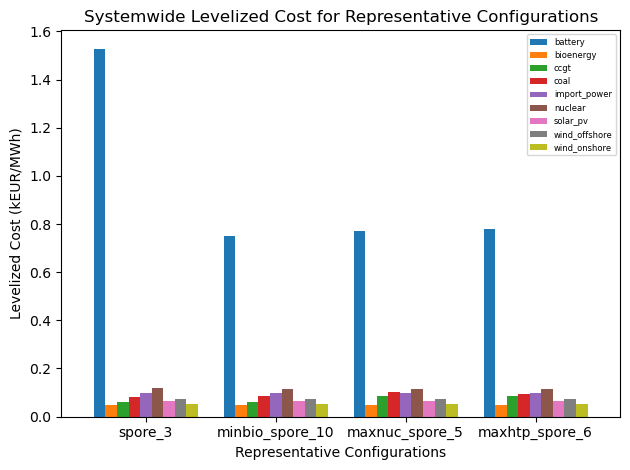

techs,battery,bioenergy,ccgt,coal,import_power,nuclear,solar_pv,wind_offshore,wind_onshore
spore_3,1.528161,0.049629,0.061511,0.082348,0.1,0.118027,0.064183,0.071888,0.054184
minbio_spore_10,0.752217,0.048677,0.061272,0.084367,0.1,0.114333,0.064183,0.071631,0.050539
maxnuc_spore_5,0.770561,0.048711,0.085508,0.101161,0.1,0.114333,0.064183,0.071631,0.054183
maxhtp_spore_6,0.778190,0.048755,0.085780,0.092451,0.1,0.114334,0.064183,0.071631,0.054183


In [33]:
plt.figure(figsize=(14, 7))
df_levelized_cost = df_levelized_cost.drop(columns=['hydrogen_power_storage'])
df_levelized_cost.plot(kind='bar', stacked=False, width=0.8)
plt.title('Systemwide Levelized Cost for Representative Configurations')
plt.xlabel('Representative Configurations')
plt.ylabel('Levelized Cost (kEUR/MWh)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.legend(loc='upper right', prop={'size': 6})
plt.show()

df_levelized_cost

Displays the DataFrame of systemwide capacity factor for the representative configurations.

<Figure size 1400x700 with 0 Axes>

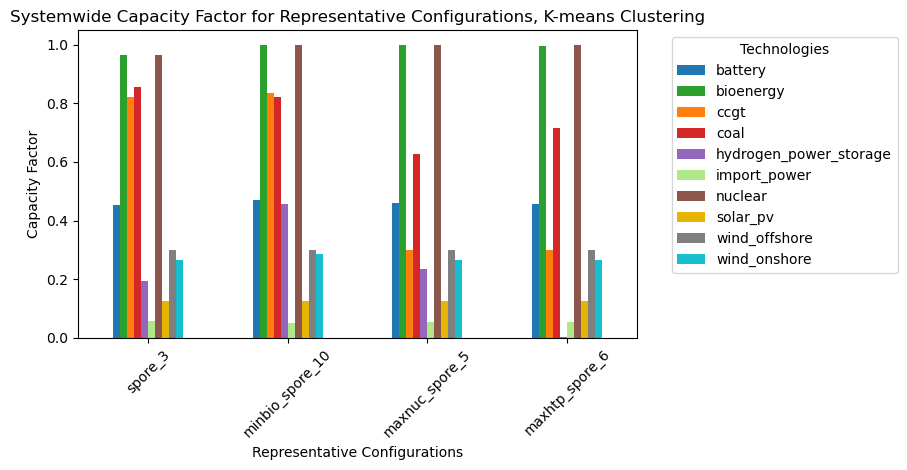

techs,battery,bioenergy,ccgt,coal,hydrogen_power_storage,import_power,nuclear,solar_pv,wind_offshore,wind_onshore
spore_3,0.454575,0.967206,0.821015,0.854841,0.192410,0.057905,0.964489,0.123826,0.298094,0.264516
minbio_spore_10,0.471802,0.999734,0.835402,0.823050,0.455441,0.049582,1.000000,0.123826,0.299166,0.284182
maxnuc_spore_5,0.460972,0.998545,0.300580,0.628577,0.234395,0.052637,0.999999,0.123826,0.299165,0.264519
maxhtp_spore_6,0.456562,0.996996,0.298431,0.716362,0.000533,0.052454,0.999996,0.123826,0.299165,0.264519


In [34]:
plt.figure(figsize=(14, 7))
colors = ['#1f77b4','#2ca02c','#ff7f0e', '#d62728', '#9467bd', "#afe789", '#8c564b',"#e6b503", '#7f7f7f', '#17becf']
df_capacity_factor.plot(kind='bar', stacked=False, color=colors)
plt.title('Systemwide Capacity Factor for Representative Configurations, K-means Clustering')
plt.xlabel('Representative Configurations')
plt.ylabel('Capacity Factor')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Technologies', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

df_capacity_factor

In [35]:
with pd.ExcelWriter('results/output_kmeans_2.xlsx', engine='openpyxl') as writer:
    df_capacity_factor.to_excel(writer, sheet_name='systemwide_capacity_factor', index=False)
    df_levelized_cost.to_excel(writer, sheet_name='systemwide_levelized_cost', index=False)
    cluster_spore_count.to_excel(writer, sheet_name='spore_count', index=True)
    cluster_summary.to_excel(writer, sheet_name='cluster_summary', index=True)
    df_representative_configs.to_excel(writer, sheet_name='representative_configs', index=True)
    metrics_summary.to_excel(writer, sheet_name='metrics_summary', index=False)